# Deutsch-Jozsa Algorithm
> Edited from Qiskit textbook by BoSeong Kim

In this section, we first introduce the Deutsch-Jozsa problem, and classical and quantum algorithms to solve it. We then implement the quantum algorithm using Qiskit, and run it on a simulator and device.

## Contents

1. [Introduction](#introduction)     
   1.1 [Deutsch-Jozsa Problem](#djproblem)    
   1.2 [Deutsch-Jozsa Algorithm](#classical-solution)    
   1.3 [The Quantum Solution](#quantum-solution)    
   1.4 [Why Does This Work?](#why-does-this-work)     
2. [Worked Example](#example) (skipped!)
3. [Creating Quantum Oracles](#creating-quantum-oracles) (skipped!)
4. [Qiskit Implementation](#implementation)  
   4.1 [Constant Oracle](#const_oracle)     
   4.2 [Balanced Oracle](#balanced_oracle)  
   4.3 [The Full Algorithm](#full_alg)     
   4.4 [Generalised Circuit](#general_circs) (skipped!)
5. [Running on Real Devices](#device) (skipped!)
6. [Problems](#problems)
7. [References](#references)

## 1. Introduction <a id='introduction'></a>

The Deutsch-Jozsa algorithm, first introduced in Reference [1], was the first example of a quantum algorithm that performs better than the best classical algorithm. It showed that there can be advantages to using a quantum computer as a computational tool for a specific problem.

### 1.1 Deutsch-Jozsa Problem <a id='djproblem'> </a>

We are given a hidden Boolean function $f$, which takes as input a string of bits, and returns either $0$ or $1$, that is:

$$
f(\{x_0,x_1,x_2,...\}) \rightarrow 0 \textrm{ or } 1 \textrm{ , where } x_n \textrm{ is } 0 \textrm{ or } 1$$

The property of the given Boolean function is that it is guaranteed to either be balanced or constant. A constant function returns all $0$'s or all $1$'s for any input, while a balanced function returns $0$'s for exactly half of all inputs and $1$'s for the other half. Our task is to determine whether the given function is balanced or constant. 

Note that the Deutsch-Jozsa problem is an $n$-bit extension of the single bit Deutsch problem. 

### 1.2 The Classical Solution <a id='classical-solution'> </a>

Classically, in the best case, two queries to the oracle can determine if the hidden Boolean function, $f(x)$, is balanced: 
e.g. if we get both $f(0,0,0,...)\rightarrow 0$ and $f(1,0,0,...) \rightarrow 1$, then we know the function is balanced as we have obtained the two different outputs.  

In the worst case, if we continue to see the same output for each input we try, we will have to check exactly half of all possible inputs plus one in order to be certain that $f(x)$ is constant. Since the total number of possible inputs is $2^n$, this implies that we need $2^{n-1}+1$ trial inputs to be certain that $f(x)$ is constant in the worst case. For example, for a $4$-bit string, if we checked $8$ out of the $16$ possible combinations, getting all $0$'s, it is still possible that the $9^\textrm{th}$ input returns a $1$ and $f(x)$ is balanced. Probabilistically, this is a very unlikely event. In fact, if we get the same result continually in succession, we can express the probability that the function is constant as a function of $k$ inputs as:



$$ P_\textrm{constant}(k) = 1 - \frac{1}{2^{k-1}} \qquad \textrm{for } 1 < k \leq 2^{n-1}$$



Realistically, we could opt to truncate our classical algorithm early, say if we were over x% confident. But if we want to be 100% confident, we would need to check $2^{n-1}+1$ inputs.

### 1.3 Quantum Solution <a id='quantum-solution'> </a>

Using a quantum computer, we can solve this problem with 100% confidence after only one call to the function $f(x)$, provided we have the function $f$ implemented as a quantum oracle, which maps the state $\vert x\rangle \vert y\rangle $ to $ \vert x\rangle \vert y \oplus f(x)\rangle$, where $\oplus$ is addition modulo $2$. Below is the generic circuit for the Deutsch-Jozsa algorithm.

![image1](images/deutsch_steps.png)

Now, let's go through the steps of the algorithm:

<ol>
   <li>
        Prepare two quantum registers. The first is an $n$-qubit register initialized to $|0\rangle$, and the second is a one-qubit register initialized to $|1\rangle$:
        

$$\vert \psi_0 \rangle = \vert0\rangle^{\otimes n} \vert 1\rangle$$


   </li>
    
   <li>
        Apply a Hadamard gate to each qubit:
        

$$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle \left(|0\rangle - |1 \rangle \right)$$


   </li>
   
   <li>
        Apply the quantum oracle $\vert x\rangle \vert y\rangle$ to $\vert x\rangle \vert y \oplus f(x)\rangle$:
        $$
            \begin{aligned}
            \lvert \psi_2 \rangle  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle (\vert f(x)\rangle - \vert 1 \oplus f(x)\rangle) \\  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle ( |0\rangle - |1\rangle ) 
        \end{aligned}
        $$
       
since for each $x,f(x)$ is either $0$ or $1$.
   </li>

   <li>
       At this point the second single qubit register may be ignored. Apply a Hadamard gate to each qubit in the first register:
        $$
        \begin{aligned}
            \lvert \psi_3 \rangle 
                & = \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)}
                    \left[ \sum_{y=0}^{2^n-1}(-1)^{x \cdot y} 
                    \vert y \rangle \right] \\
                & = \frac{1}{2^n}\sum_{y=0}^{2^n-1}
                    \left[ \sum_{x=0}^{2^n-1}(-1)^{f(x)}(-1)^{x \cdot y} \right]
                    \vert y \rangle
        \end{aligned}
        $$
       
where $x \cdot y = x_0y_0 \oplus x_1y_1 \oplus \ldots \oplus x_{n-1}y_{n-1}$ is the sum of the bitwise product.
   </li>

   <li>
       Measure the first register. Notice that the probability of measuring $\vert 0 \rangle ^{\otimes n} = \lvert \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)} \rvert^2$, which evaluates to $1$ if $f(x)$ is constant and $0$ if $f(x)$ is balanced. 
   </li>

</ol>

### 1.4 Why Does This Work? <a id='why-does-this-work'> </a>

- **Constant Oracle**

When the oracle is *constant*, it has no effect (up to a global phase) on the input qubits, and the quantum states before and after querying the oracle are the same. Since the H-gate is its own inverse, in Step 4 we reverse Step 2 to obtain the initial quantum state of $|00\dots 0\rangle$ in the first register.

$$
H^{\otimes n}\begin{bmatrix} 1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix} 
= 
\tfrac{1}{\sqrt{2^n}}\begin{bmatrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}
\quad \xrightarrow{\text{after } U_f} \quad
H^{\otimes n}\tfrac{1}{\sqrt{2^n}}\begin{bmatrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}
= 
\begin{bmatrix} 1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix} 
$$

- **Balanced Oracle**

After step 2, our input register is an equal superposition of all the states in the computational basis. When the oracle is *balanced*, phase kickback adds a negative phase to exactly half these states:

$$
U_f \tfrac{1}{\sqrt{2^n}}\begin{bmatrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix} 
= 
\tfrac{1}{\sqrt{2^n}}\begin{bmatrix} -1 \\ 1 \\ -1 \\ \vdots \\ 1 \end{bmatrix}
$$


The quantum state after querying the oracle is orthogonal to the quantum state before querying the oracle. Thus, in Step 4, when applying the H-gates, we must end up with a quantum state that is orthogonal to $|00\dots 0\rangle$. This means we should never measure the all-zero state. 


## 4. Qiskit Implementation <a id='implementation'></a>

We now implement the Deutsch-Jozsa algorithm for the example of a three-bit function, with both constant and balanced oracles. First let's do our imports:

In [1]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

Next, we set the size of the input register for our oracle:

In [2]:
# set the length of the n-bit input string. 
n = 3

### 4.1 Constant Oracle <a id='const_oracle'></a>
Let's start by creating a constant oracle, in this case the input has no effect on the output so we just randomly set the output qubit to be 0 or 1:

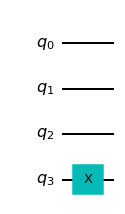

In [3]:
const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

const_oracle.draw()

### 4.2 Balanced Oracle <a id='balanced_oracle'></a>

Next, we construct a balanced oracle, applying some controlled-NOT gates.

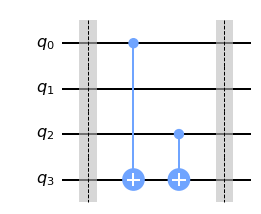

In [4]:
balanced_oracle = QuantumCircuit(n+1)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
balanced_oracle.cx(0, n)
balanced_oracle.cx(2, n)

balanced_oracle.barrier()
balanced_oracle.draw()

We have just created a balanced oracle! All that's left to do is see if the Deutsch-Jozsa algorithm can solve it.

### 4.3 The Full Algorithm <a id='full_alg'></a>

Let's now put everything together. This first step in the algorithm is to initialize the input qubits in the state $|{+}\rangle$ and the output qubit in the state $|{-}\rangle$:

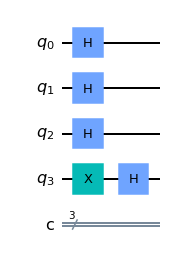

In [5]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)
dj_circuit.draw()

Next, let's apply the oracle. Here we apply the `balanced_oracle` we created above:

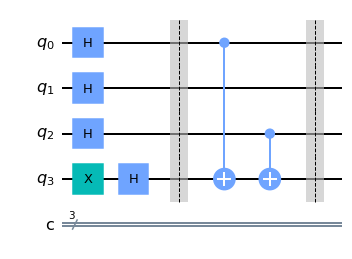

In [6]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit.compose(balanced_oracle, inplace=True)
dj_circuit.draw()

Finally, we perform H-gates on the $n$-input qubits, and measure our input register:

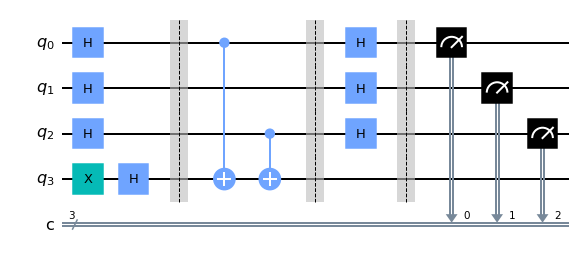

In [7]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit.compose(balanced_oracle, inplace=True)

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw()

Let's see the output:

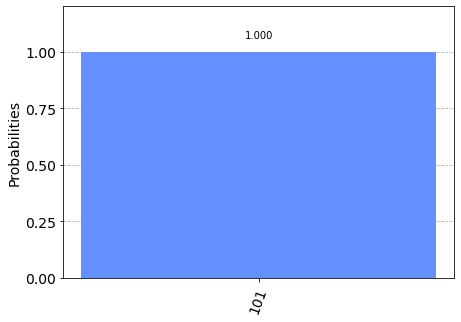

In [8]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
qobj = assemble(transpiled_dj_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

We can see from the results above that we have 100% chance of measuring `101`, along with the 0% chance of measuring `000`. This correctly predicts the function is balanced. 

## 6. Problems <a id='problems'></a>

The function `dj_problem_oracle` (below) returns a Deutsch-Jozsa oracle for `n = 4` in the form of a gate. The gate takes 5 qubits as input where the final qubit (`q_4`) is the output qubit (as with the example oracles above). You can get different oracles by giving `dj_problem_oracle` different integers between 1 and 5. Use the Deutsch-Jozsa algorithm to decide whether each oracle is balanced or constant (**Note:** It is highly recommended you try this example using the `aer_simulator` instead of a real device).

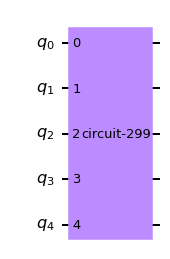

In [9]:
from qiskit_textbook.problems import dj_problem_oracle

oracle_index = 1

n = 4
dj_oracle = QuantumCircuit(n+1)
dj_oracle.append(dj_problem_oracle(oracle_index), range(n+1))
dj_oracle.draw()

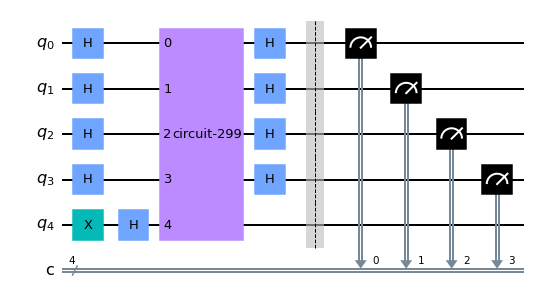

In [10]:
dj_circuit = QuantumCircuit(n+1, n)

####################
# Your codes Here

####################

# Display circuit
dj_circuit.draw()

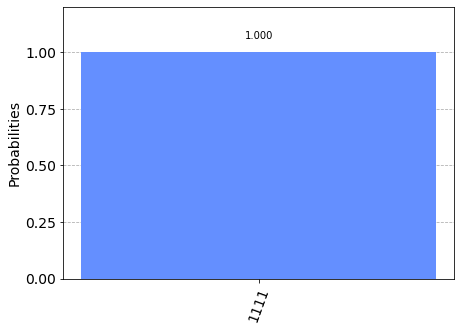

In [11]:
# Check your answer
aer_sim = Aer.get_backend('aer_simulator')
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
qobj = assemble(transpiled_dj_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

## 7. References <a id='references'></a>

1. David Deutsch and Richard Jozsa (1992). "Rapid solutions of problems by quantum computation". Proceedings of the Royal Society of London A. 439: 553–558.  [doi:10.1098/rspa.1992.0167](https://doi.org/10.1098%2Frspa.1992.0167).
2. R. Cleve; A. Ekert; C. Macchiavello; M. Mosca (1998). "Quantum algorithms revisited". Proceedings of the Royal Society of London A. 454: 339–354. [doi:10.1098/rspa.1998.0164](https://doi.org/10.1098%2Frspa.1998.0164).

In [12]:
import qiskit.tools.jupyter
%qiskit_version_table